<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Calibration Notebook #1 (Detailed Spec2/Spec3 Walkthrough) #

**Author**: David Law, AURA Associate Astronomer, MIRI branch
<br>
**Last Updated**: October 05, 2021
<br>
**Pipeline Version**: 1.3.2

## Table of contents
1. [Introduction](#intro)<br>
   1.1 [Purpose of this Notebook](#purpose)<br>
   1.2 [Input Simulations](#inputs)<br>
   1.3 [Caveats for Simulated Data](#mirisim)<br>
2. [Setup](#setup)<br>
   2.1 [CRDS Context](#crds)<br>
   2.2 [Python Imports](#imports)<br>
   2.3 [Data I/O Directories](#iodir)<br>
   2.4 [Reprocessing Flag](#redo)<br>
3. [Detector1 Pipeline](#det1)<br>
4. [Spec2 Pipeline](#spec2)<br>
   4.1 [Assign WCS](#wcs)<br>
   4.2 [Pixel-wise Background Subtraction](#spec2bg)<br>
   4.3 [Imprint Subtraction and MSA Failed-Open Flagging (<font color='fuchsia'>NIRSpec-only</font>)](#imprintmsa)<br>
   4.4 [Flatfield Correction](#flat)<br>
   4.5 [Source Type Identification](#stype)<br>
   4.6 [Straylight Subtraction (<font color='red'>MIRI-only</font>)](#stray)<br>
   4.7 [Fringe Flat (<font color='red'>MIRI-only</font>)](#fringe)<br>
   4.8 [Path-Loss Correction (<font color='fuchsia'>NIRSpec-only</font>)](#pathloss)<br>
   4.9 [Flux Calibration](#fluxcal)<br>
   4.10 [Quicklook Cube Building](#spec2cube)<br>
   4.11 [Quicklook Spectral Extraction](#spec2x1d)<br>
5. [Spec3 Pipeline](#spec3)<br>
   5.1 [Association Files](#l3assoc)<br>
   5.2 [Moving Target WCS](#spec3wcs)<br>
   5.3 [Master Background Subtraction](#masterbg)<br>
   5.4 [Residual Background Matching (<font color='red'>MIRI-only</font>)](#residbg)<br>
   5.5 [Outlier Detection](#orej)<br>
   5.6 [Cube Creation](#spec3cube)<br>
   5.7 [Spectral Extraction](#spec3x1d)<br>

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

### 1.1<font color='white'>-</font>Purpose of this Notebook<a class="anchor" id="purpose"></a> ###

In this notebook we provide an introduction to JWST spectroscopic mode data reduction, focusing on the specific use case of the integral-field unit (IFU) observing mode.  As a demonstration case we use IFU data for the MIRI Medium Resolution Spectrometer (MRS) IFU; while many of the pipeline steps are similar for both MIRI and NIRSpec IFUs we note differences where they arise.

We will start with a simple simulated MRS point source observation (created using mirisim: https://wiki.miricle.org/Public/MIRISim_Public), process the data through the Detector1 pipeline (which turns raw detector counts into uncalibrated rate images), the Spec2 pipeline (which turns uncalibrated rate images into calibrated rate images), and the Spec3 pipeline (which turns calibrated rate images into composite data cubes and extracted 1d spectra).

Since the Detector1 pipeline has been discussed extensively in previous JWebbinars we will not dig into that stage of the pipeline in detail, and focus instead on the Spec2 and Spec3 stages.  We will step individually through each step in these two pipeline stages, discuss how they work, and examine some sample outputs.  Since we'll be examining each step individually, this notebook is thus not a good template to use for designing your own notebook to process/inspect large quantities of observational data.  This use case is more directly addressed by MRS Calibration Notebooks #2 and #3 (point sources and extended sources respectively).

A few additional caveats:
- This notebook covers the v1.3.2 baseline pipeline as it existed in October 2021.  The pipeline is under continuous development and there are therefore some changes in the latest pipeline build that will not be reflected here.
- Likewise, there are some advanced algorithms slated for development prior to cycle 1 observations that will not be discussed here.

### 1.2<font color='white'>-</font>Input Simulations<a class="anchor" id="inputs"></a> ###

As input to this notebook, we'll be using a 4-pt dithered observation of a point source created using mirisim that covers the 1C and 2C bands (i.e., just one of the two MIRI detectors, with the LONG grating configuration).  The point source spectrum is chosen to be astrophysically realistic, in this case taken from the galaxy NGC 5728.

<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/scene1.png' alt="nb1input" width="900px"/> 

### 1.3<font color='white'>-</font>Caveats for Simulated Data<a class="anchor" id="mirisim"></a> ###

As noted above, in this notebook we will be processing simulated data created with the 'mirisim' tool.  Like the pipeline, mirisim is also an evolving piece of software and there are multiple known issues that can cause problems.  A few of the most important such mirisim issues include:

- FAST mode has incorrect noise properties, rendering FAST mode data processed by the pipeline unreliable.  The simulations in this notebook therefore use simulated SLOW mode data.

- Extended sources are not simulated unless they meet a minimum size that varies with each band.

- Point sources are not simulated properly, with the PSF profile being simulated incorrectly in the cores.  Mirisim simulations therefore should not be used to study the PSF shape.

- Reference pixels are not treated consistently, the refpix step of detector1 must therefore be turned off to process mirisim data without artifacts.

- Channel 4 flux calibration is incorrect in mirisim.  No workaround is currently available- channel 4 fluxes provided by the pipeline from simulated data will be incorrect.

- WCS alignment is incorrect in mirisim, causing sources to jump in location by a couple of pixels between channels.  No workaround is available- do not use mirisim data to test spatial alignment.

- Flux conservation is not perfect within mirisim.  Likewise, the aperture correction factors in use by the pipeline correspond to the expected performance in flight (to be udpated during on-orbit commissioning) and are not well matched to mirisim data.  No workaround available, do not use mirisim data to test flux conservation.

- mirisim does not add all of the necessary header keywords for the pipeline to know how to do background subtraction, identify source type, etc.  In order to get these APT-derived keywords correct they will need to be set manually.

<hr style="border:1px solid gray"> </hr>

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we set things up a number of necessary things in order for the pipeline to run successfully.

First we'll import the various python packages that we're actually going to use in this notebook, including both generic utility functions and the actual pipeline modules themselves.

Next, we'll specify the data directory structure that we want to use.  In order to keep our filesystem clean we'll separate simulated inputs and outputs from each pipeline stage into their own folders.

Finally, for convenience in this JWebbinar we'll define a flag that sets whether or not to actually run some of the longer pipeline steps in this notebook or just to rely upon cached reductions provided ahead of time.  This is because some steps can take quite a long time to run, and in a short Webbinar we don't want to be waiting for them to all run in real time.  This flag is set to False by default for use in the live Webbinar; if you want to experiment with running all steps yourself ahead of time just set this flag to True.  Total notebook runtime with True/False values is about 15 minutes vs 6 minutes.

Note that this runtime reflects substantial gains in the speed of 3d cube building in the build 1.3.2 JWST pipeline, which now uses C routines to perform cube building instead of pure python.  Previously, total notebook runtime was approximately 1.5 hours.

### 2.1<font color='white'>-</font>CRDS Context<a class="anchor" id="crds"></a> ###

If we wanted to set a specific CRDS reference file context (see https://jwst-crds.stsci.edu/) we would do it here.  However, it is not currently necessary for version 1.3.2 of the pipeline.

In [1]:
# Comment out this line if you want to use the latest reference files tagged for a specific pipeline version
#%env CRDS_CONTEXT jwst_0771.pmap

### 2.2<font color='white'>-</font>Python Imports <a class="anchor" id="imports"></a> ###

In [2]:
# First let's use the entire available screen width for the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# Basic system utilities for interacting with files
import glob
import sys
import os
import time
import shutil
import warnings
import zipfile
import urllib.request

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
from astropy.utils.data import download_file
# Astropy utilities for making plots
from astropy.visualization import LinearStretch, LogStretch, ImageNormalize, ZScaleInterval

# Numpy for doing calculations
import numpy as np

# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [4]:
# Import the base JWST package and warn if not the expected version
import jwst

if jwst.__version__ != '1.3.2':
    warnings.warn(f"You are running version {jwst.__version__} of the jwst "
                  "module instead of the intended 1.3.2.")
else:
    print('JWST pipeline version', jwst.__version__)

JWST pipeline version 1.3.2


In [5]:
# JWST pipelines (encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# Individual JWST pipeline steps
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst.flatfield import FlatFieldStep
from jwst.srctype import SourceTypeStep
from jwst.straylight import StraylightStep
from jwst.fringe import FringeStep
from jwst.photom import PhotomStep
from jwst.cube_build import CubeBuildStep
from jwst.extract_1d import Extract1dStep
from jwst.cube_skymatch import CubeSkyMatchStep
from jwst.master_background import MasterBackgroundStep
from jwst.outlier_detection import OutlierDetectionStep

# JWST pipeline utilities
from jwst import datamodels # JWST datamodels
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

from stcal import dqflags # Utilities for working with the data quality (DQ) arrays

### 2.3<font color='white'>-</font>Data I/O Directories <a class="anchor" id="iodir"></a> ###

Data for this notebook comes in two parts, a stage0/ directory that contains the mirisim inputs to the pipeline, and a cache/ directory containing pre-reduced stage1, stage2, and stage3 pipeline results.  This cache directory is intended to provide reference examples against which new reductions can be compared, or to serve as the source of intermediate-stage pipeline inputs if skipping lengthy processing steps in this notebook.

These directories are zipped together and can be downloaded from Box automatically using the code below.  However, since the zip file is quite large (~ 1 GB) it can also be downloaded through any other means and extracted into the target data directory.

In [6]:
# input_dir should point to where you installed the data from Box
input_dir = './'

ziplink = 'https://stsci.box.com/shared/static/gcphs4m12j7l8zmqj4cgbmw0be12dzz3.zip'
zipfilename = 'mrs_data1.zip'

# Look for a stage0/ directory, if not found then download the data
if os.path.isdir(os.path.join(input_dir, 'stage0/')):
    print('stage0/ input directory already exists, skipping download.')
else:
    print('Downloading {}...'.format(zipfilename))
    demo_file = download_file(ziplink, cache=True)
    # Make a symbolic link using a local name for convenience
    os.symlink(demo_file, os.path.join(input_dir, zipfilename))
    zf = zipfile.ZipFile(os.path.join(input_dir, zipfilename), 'r')
    print('Extracting zip file...')
    zf.extractall(input_dir)
    print('Cleaning up.')
    os.remove(os.path.join(input_dir, zipfilename))

stage0/ input directory already exists, skipping download.


In [7]:
# Set up mirisim input path
mirisim_dir = os.path.join(input_dir, 'stage0/') # Simulated inputs are here

# Set up cache paths
det1_cachedir = os.path.join(input_dir, 'cache/stage1/') # Cached Detector1 pipeline outputs are here
spec2_cachedir = os.path.join(input_dir, 'cache/stage2/') # Cached Spec2 pipeline outputs are here
spec3_cachedir = os.path.join(input_dir, 'cache/stage3/') # Cached Spec3 pipeline outputs are here

In [8]:
# output_dir should point to where you want the output results to go
output_dir = './'

# Specify output directories to keep data products organized
det1_dir = os.path.join(output_dir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_dir = os.path.join(output_dir, 'stage2/') # Spec2 pipeline outputs will go here
spec3_dir = os.path.join(output_dir, 'stage3/') # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)

### 2.4<font color='white'>-</font>Reprocessing Flag<a class="anchor" id="redo"></a> ###

Since some parts of the pipeline take a long time to run, for a first use of this notebook we will disable those steps and simply copy results out of the cache for informational purposes.  In order to run the full pipeline on the data, or to run this notebook on your own simulated data not downloaded from the Box link above, this reprocessing flag will need to be enabled.

In [9]:
# To rerun all steps use:
# redolong = True
# To skip lengthy steps and copy results from the cache use:
redolong = False

# If skipping lengthy steps, check that the cache has been installed properly
if (redolong is False):
    if not os.path.exists(det1_cachedir):
        print('Could not find cache, running all steps.')
        redolong = True

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Detector1 Pipeline <a class="anchor" id="det1"></a>
------------------
<div class="alert alert-block alert-warning">

In this section we process our simulated data through the Detector1 pipeline to create Lvl2a data products (i.e., uncalibrated slope images).  We won't go into detail however, as these steps are treated in detail elsewhere.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html
    
</div>

In [10]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

In [11]:
# First we'll define a function that will call the detector1 pipeline with our desired set of parameters:
def rundet1(filenames):
    det1 = Detector1Pipeline() # Instantiate the pipeline
    det1.output_dir = det1_dir # Specify where the output should go
    det1.refpix.skip = True # Skip the reference pixel subtraction (as it doesn't interact well with simulated data)
    det1.save_results = True # Save the final resulting _rate.fits files
    det1(filenames) # Run the pipeline on an input list of files

In [12]:
# Now let's look for input files in our (cached) mirisim simulation directory
sstring = mirisim_dir + 'det*exp1.fits'
simfiles = sorted(glob.glob(sstring))
print('Found ' + str(len(simfiles)) + ' input files to process')

Found 4 input files to process


In [13]:
# Run the pipeline on these input files by a simple loop over our pipeline function

# If rerunning long pipeline steps, actually run the step
if (redolong is True):
    for file in simfiles:
        rundet1(file)
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(det1_cachedir, 'det*rate.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, det1_cachedir, det1_dir)
        shutil.copy(file, outfile)

Let's take a look at the output data products (i.e., uncalibrated slope data) to get an idea what they look like.

In [14]:
# Look for our _rate.fits files produced by the Detector1 pipeline
sstring = det1_dir + 'det*rate.fits'
ratefiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
ratefiles

['./stage1/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits',
 './stage1/det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits',
 './stage1/det_image_seq3_MIRIFUSHORT_12LONGexp1_rate.fits',
 './stage1/det_image_seq4_MIRIFUSHORT_12LONGexp1_rate.fits']

In [15]:
# We'll open the first image in the list and take a look at its contents
hdu1 = fits.open(ratefiles[0])
hdu1.info()

Filename: ./stage1/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     131   ()      
  1  SCI           1 ImageHDU        46   (1032, 1024)   float32   
  2  ERR           1 ImageHDU        10   (1032, 1024)   float32   
  3  DQ            1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (1032, 1024)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (1032, 1024)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [3645B]   


Text(0.5, 0, 'X pixel')

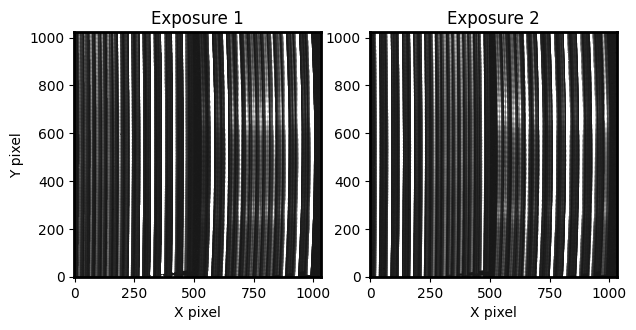

In [16]:
# Let's show what the SCI extension of the first two files looks like
image1 = hdu1['SCI'].data
hdu2 = fits.open(ratefiles[1])
image2 = hdu2['SCI'].data

# Use a classic ZScale normalization
norm = ImageNormalize(image1, interval=ZScaleInterval(), stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data
ax1.imshow(image1, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Exposure 1')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')

ax2.imshow(image2, cmap='gray', norm=norm, origin='lower')
ax2.set_title('Exposure 2')
ax2.set_xlabel('X pixel')

<b>Figure 1:</b> Each exposure above shows the slope image for a MIRI MRS exposure.  X pixels 1-500 (roughly) correspond to data from Channel 1, and pixels 500-1024 correspond to data from Channel 2.  Data are dispersed along the spectral Y axis in each of multiple slices.  In this example of a bright point source, the point source is visible in many different slices- note how different slices are illuminated in Exposure 1 vs Exposure 2 though as we have dithered the source location between the two.

In [17]:
# Close our files behind us
hdu1.close()
hdu2.close()

In [18]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 0.6076 seconds


We're now done with the Detector1 pipeline!

<hr style="border:1px solid gray"> </hr>

4.<font color='white'>-</font>Spec2 Pipeline <a class="anchor" id="spec2"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our simulated data through the Spec2 pipeline in order to produce Lvl2b data products (i.e., calibrated slope images and quick-look data cubes).  Since we're going to run each step of this pipeline individually we won't set up a master spec2 pipeline function- see Notebook #2 for a guide to doing that.

Note that the individual steps ordinarily wouldn't produce output files if we were running Spec2 as a pipeline; they would just feed from one step directly into the next.  However, we'll break them out individual here so that we can inspect them.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

### 4.1<font color='white'>-</font>Assign WCS <a class="anchor" id="wcs"></a> ###

<div class="alert alert-block alert-warning">
This first step is critical for many later stages of the pipeline; this is where the distortion solution of the instrument is put together with the various telescope pointing keywords to determine the overall world coordinate solution mapping detector pixels to their RA, DEC, WAVELENGTH on the sky.  This transformation is extremely complex for the MRS, which has many slices for each of two channels that both map to overlapping regions of the sky simultaneously at different wavelengths.  This information will be stored in an ASDF extension to the FITS file which can be queried using the JWST datamodels code, or both other ASDF parsers.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html
</div>

In [19]:
# Call the step, specifying that we want results saved into the spec2_dir directory
for file in ratefiles:
    AssignWcsStep.call(file, save_results=True, output_dir=spec2_dir)

2021-10-05 16:55:24,086 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-10-05 16:55:24,165 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('./stage1/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits',).
2021-10-05 16:55:24,167 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-10-05 16:55:27,253 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'spec

2021-10-05 16:55:43,501 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  359.999035322 -0.000942272 0.000378529 -0.000942272 0.000378529 0.000482700 359.999035322 0.000482700
2021-10-05 16:55:43,502 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2021-10-05 16:55:44,378 - stpipe.AssignWcsStep - INFO - Saved model in ./stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits
2021-10-05 16:55:44,378 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


In [20]:
# Look for the _assignwcsstep.fits files produced by this step
sstring = spec2_dir + 'det*assignwcsstep.fits'
wcsfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
wcsfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits']

The assign_wcs step doesn't modify the science data, so this will look identical to the \_rate.fits files above.  However, now the ASDF extension contains all of the information about the distortion transforms between detector pixel values and world coordinates.  A detailed treatment of how to interact with this WCS is beyond the scope of this notebook, but we can show an example quickly:

In [21]:
# Open the first file using the JWST datamodels
image = datamodels.ImageModel(wcsfiles[0])

# And show the available transforms
print(image.meta.wcs)

   From       Transform   
---------- ---------------
  detector detector_to_abl
alpha_beta    abl_to_v2v3l
      v2v3   CompoundModel
v2v3vacorr   CompoundModel
     world            None


In [22]:
# Here's an example transformation giving the world coordinates of pixel x=376,y=589
ra, dec, wave = image.meta.wcs.transform("detector", "world", 376, 589)
print('RA = ', ra, ' deg')
print('DEC = ', dec, ' deg')
print('Wavelength = ', wave, ' micron')

RA =  0.0001283481524160032  deg
DEC =  2.2568993088226966e-05  deg
Wavelength =  7.084169606446311  micron


### 4.2<font color='white'>-</font>Pixel-wise background subtraction <a class="anchor" id="spec2bg"></a> ###

<div class="alert alert-block alert-warning">
The MIRI MRS is expected to see a substantial background signal, especially in Channel 4 where the telescope thermal background becomes significant.  It will therefore be necessary to subtract this background (strictly, a foreground) signal from the data prior to analysis.  Ideally, this background should be sufficiently smooth and uniform that it is possible to model it and subtract the model from the science data (see Spec3- Master Background).  However, it is possible that the signal has sufficient spatial/spectral variability that it may prove necessary to do background subtraction via direct subtraction of on/off pointings.

This background step in the Spec2 pipeline is largely a placeholder for if it becomes necessary to do such a direct subtraction at the cost of increased total noise.  As such, we do not recommend running this step at the present time- additional guidance will be provided after on-orbit commissioning.  If we *were* to run the step, here's one way in which in could be done.


See https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/
</div>

In [23]:
# Look for our assignwcsstep.fits files produced by the assign_wcs step
sstring = spec2_dir + 'det*assignwcsstep.fits'
wcsfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
wcsfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits']

Define which exposures we're going to call background pointings for each science exposure.  If we were observing an extended source with a dedicated background this would be easy- the background pointings are any dedicated background observations.  Since we're simulating dithered point source observations however this is a little trickier.  With a four-point dither pattern we have A-B-A'-B' pointings; where the A-B offset distance is large and the A' and B' pointings are close to the A and B pointings respectively.  We'll use A/B and A'/B' as background pairs.

In [24]:
# Alternate background assignments
bgfiles = wcsfiles.copy()
bgfiles[0] = wcsfiles[1]
bgfiles[1] = wcsfiles[0]
bgfiles[2] = wcsfiles[3]
bgfiles[3] = wcsfiles[2]

In [25]:
# Loop over the input files, specifying background to subtract from each
for ii in range(0, 4):
    BackgroundStep.call(wcsfiles[ii], [bgfiles[ii]], save_results=True, output_dir=spec2_dir)

2021-10-05 16:55:46,958 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.
2021-10-05 16:55:47,080 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args ('./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits', ['./stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits']).
2021-10-05 16:55:47,083 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2021-10-05 16:55:51,860 - stpipe.BackgroundStep - INFO - Saved model in ./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_backgroundstep.fits
2021-10-05 16:55:51,860 - stpipe.BackgroundStep - INFO - Step BackgroundStep done
2021-10-05 16:55:53,249 - stpipe.B

In [26]:
# Look for our backgroundstep.fits files produced by the background step
sstring = spec2_dir + 'det*backgroundstep.fits'

bgfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
bgfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_backgroundstep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_backgroundstep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_backgroundstep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_backgroundstep.fits']

Text(0.5, 0, 'X pixel')

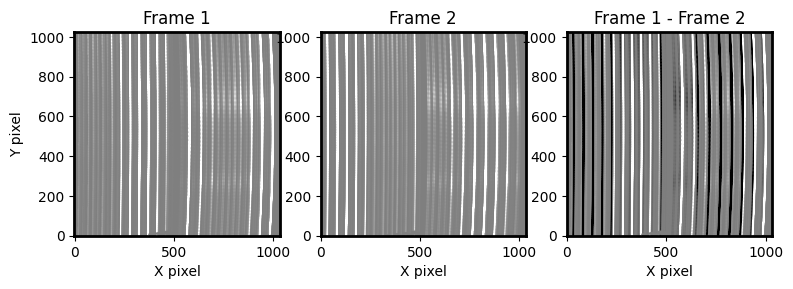

In [27]:
# Let's take a quick look at what it did by reading in the original 
# exposures 1 and 2, and the modified exposure 1
hdu1 = fits.open(wcsfiles[0])
image1 = hdu1['SCI'].data
hdu2 = fits.open(wcsfiles[1])
image2 = hdu2['SCI'].data
hdu3 = fits.open(bgfiles[0])
image3 = hdu3['SCI'].data

# Use a classic ZScale normalization
norm = ImageNormalize(image3, interval=ZScaleInterval(), stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 7), dpi=100)

# And plot the data
ax1.imshow(image1, cmap='gray', origin='lower', norm=norm)
ax1.set_title('Frame 1')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')

ax2.imshow(image2, cmap='gray', origin='lower', norm=norm)
ax2.set_title('Frame 2')
ax2.set_xlabel('X pixel')

ax3.imshow(image3, cmap='gray', origin='lower', norm=norm)
ax3.set_title('Frame 1 - Frame 2')
ax3.set_xlabel('X pixel')

<b>Figure 2:</b> Data before and after Spec2 pixel-wise background subtraction.  Frame 1 and Frame 2 show two dithered frames of point source data, the right-hand column shows the difference between them computed by this step when Frame 2 is used as the background for Frame 1.

In [28]:
# Close our files behind us
hdu1.close()
hdu2.close()
hdu3.close()

### 4.3<font color='white'>-</font>Imprint Subtraction and MSA Failed-Open Flagging (<font color='fuchsia'>NIRSpec-only</font>) <a class="anchor" id="imprintmsa"></a> ###

<div class="alert alert-block alert-warning">
These NIRSpec-specific steps account for the contamination of the detector by artifacts introduced by the microshutter array.  The imprint subtraction step subtracts a dedicated imprint exposure to remove patterns created by the microshutter array.  Likewise, the MSA failed-open flagging step identifies and flags detector pixels that are affected by stuck-open shutters in the microshutter array based on a master reference list.

We do not treat these steps in detail in the present notebook.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/imprint/index.html and https://jwst-pipeline.readthedocs.io/en/latest/jwst/msaflagopen/index.html
</div>

### 4.4<font color='white'>-</font>Flatfield correction <a class="anchor" id="flat"></a> ###

<div class="alert alert-block alert-warning">
This step divides the array data by the pixel flatfield reference file.  Ordinarily, this would therefore normalize out both differences in the pixel-to-pixel response function and differences in the pixel solid angle.  However, for MIRI MRS the reference flatfield is currently unity everywhere that light falls on the detector, so this step has no practical effect.  These corrections are instead taken care of in the PHOTOM step.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html
</div>

In [29]:
# Look for our assignwcsstep.fits files produced by the assign_wcs step
# (since we're going to skip background subtraction)
sstring = spec2_dir + 'det*assignwcsstep.fits'

wcsfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
wcsfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits']

In [30]:
# Call the step, specifying that we want results saved into the spec2_dir directory
for file in wcsfiles:
    FlatFieldStep.call(file, save_results=True, output_dir=spec2_dir)

2021-10-05 16:56:13,293 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2021-10-05 16:56:13,434 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_assignwcsstep.fits',).
2021-10-05 16:56:13,436 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2021-10-05 16:56:14,768 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2021-10-05 16:56:17,554 - stpipe.FlatFieldStep - INFO - Saved model in ./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_flatfieldstep.fits
2021-10-05 16:56:17,555 - stpipe.Fl

### 4.5<font color='white'>-</font>Source Type Identification <a class="anchor" id="stype"></a> ###

<div class="alert alert-block alert-warning">
This step attempts to determine whether the observation should be considered as a POINT or EXTENDED source, and set the SRCTYPE keyword in the science extension header accordingly.  There are no user-facing arguments that modify this step.

Each instrument uses a slightly different logic to determine which kind of source to use.  At present the logic is roughly as follows:
- If a source type was specified in APT (keyword SRCTYAPT), use that.
- If the dither pattern in use is a point-source specific pattern, assume this is a POINT source.
- If no other guidance is provided, assume the target is an EXTENDED source (for MIRI MRS) or a POINT source (for NIRSpec IFU)

Note that these are only relevant in that they set the default method by which the pipeline automatically extracts 1d spectra from the data cubes.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/srctype/index.html
</div>

In [31]:
# Look for our assignwcsstep.fits files produced by the assign_wcs step
sstring = spec2_dir + 'det*flatfieldstep.fits'
flatfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
flatfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_flatfieldstep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_flatfieldstep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_flatfieldstep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_flatfieldstep.fits']

In [32]:
# Call the step, specifying that we want results saved into the spec2_dir directory
for file in flatfiles:
    SourceTypeStep.call(file, save_results=True, output_dir=spec2_dir)

2021-10-05 16:56:35,449 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2021-10-05 16:56:35,574 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args ('./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_flatfieldstep.fits',).
2021-10-05 16:56:35,576 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-10-05 16:56:36,901 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is MIR_MRS
2021-10-05 16:56:36,902 - stpipe.SourceTypeStep - INFO - Input SRCTYAPT = None
2021-10-05 16:56:36,902 - stpipe.SourceTypeStep - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-10-05 16:56:36,903 - stpipe.SourceTypeStep - INFO - Input source type is unknown; setting default SRCTYPE 

In [33]:
# Look for our sourcetypestep.fits files produced by the source type step
sstring = spec2_dir + 'det*sourcetypestep.fits'
srcfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
srcfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_sourcetypestep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_sourcetypestep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_sourcetypestep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_sourcetypestep.fits']

In [34]:
# We can look at the keyword in the first exposure
hdu = fits.open(srcfiles[0])
print('SRCTYPE = ', hdu['SCI'].header['SRCTYPE'])
hdu.close()

SRCTYPE =  EXTENDED


In this case it was set to EXTENDED.  This can't be kludged in the pipeline step, but we'll do so directly in the files in order to tell them that we're working with a POINT source:

In [35]:
# Loop over files kludging the source type to POINT
for file in srcfiles:
    hdu = fits.open(file)
    hdu['SCI'].header['SRCTYPE'] = 'POINT'
    hdu.writeto(file, overwrite=True)
    hdu.close()

In [36]:
# Now the source type is set to POINT in the headers!
hdu = fits.open(srcfiles[0])
print('SRCTYPE = ', hdu['SCI'].header['SRCTYPE'])
hdu.close()

SRCTYPE =  POINT


### 4.6<font color='white'>-</font>Straylight Subtraction (<font color='red'>MIRI-only</font>) <a class="anchor" id="stray"></a> ###

<div class="alert alert-block alert-warning">
The MIRI MRS has been observed to have appreciable straylight at short wavelengths in ground-test data, and this step is therefore designed to model and subtract this component from the detector data using the small interstitial regions of detector pixels between the illuminated slices.  However, a limitation of the test data set that we're using is that mirisim does *not* add straylight to the data; as such, running this step on simulated data can only introduce artifacts rather than remove them.

As such, we usually recommend skipping this step when working with simulated data.  However, we'll run it here just to see what it looks like.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/straylight/index.html
</div>

In [37]:
# Call the straylight step, specifying that we want results saved into the spec2_dir directory
for file in srcfiles:
    StraylightStep.call(file, save_results=True, output_dir=spec2_dir)

2021-10-05 16:56:52,917 - stpipe.StraylightStep - INFO - StraylightStep instance created.
2021-10-05 16:56:53,148 - stpipe.StraylightStep - INFO - Step StraylightStep running with args ('./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_sourcetypestep.fits',).
2021-10-05 16:56:53,150 - stpipe.StraylightStep - INFO - Step StraylightStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'method': 'ModShepard', 'roi': 50, 'power': 1.0}
2021-10-05 16:56:54,532 - stpipe.StraylightStep - INFO - Using regions reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_regions_0028.asdf
2021-10-05 16:56:54,576 - stpipe.StraylightStep - INFO -  Using 20% throughput threshhold.
2021-10-05 16:56:54,577 - stpipe.StraylightStep - INFO -  Modified Shepard weighting power  1

In [38]:
# Look for our straylightstep.fits files produced by the straylight step
sstring = spec2_dir + 'det*straylightstep.fits'
strayfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
strayfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_straylightstep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_straylightstep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_straylightstep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_straylightstep.fits']

Text(0.5, 0, 'X pixel')

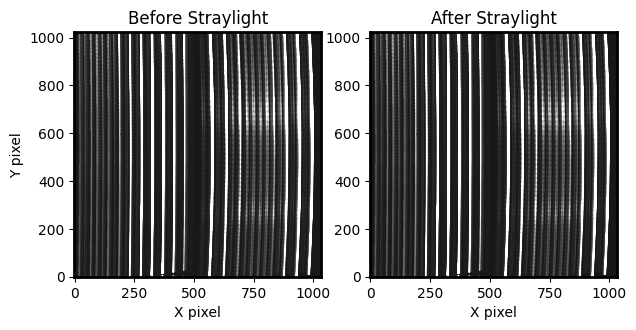

In [39]:
# Let's show what the SCI extension of the first file before/after straylight subtraction looks like
hdu1 = fits.open(srcfiles[0])
image1 = hdu1['SCI'].data
hdu2 = fits.open(strayfiles[0])
image2 = hdu2['SCI'].data

# Use a classic ZScale normalization
norm = ImageNormalize(image1, interval=ZScaleInterval(), stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data
ax1.imshow(image1, cmap='gray', origin='lower', norm=norm)
ax1.set_title('Before Straylight')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')

ax2.imshow(image2, cmap='gray', origin='lower', norm=norm)
ax2.set_title('After Straylight')
ax2.set_xlabel('X pixel')

<b>Figure 3:</b> 2d detector images of MIRI data before and after background subtraction.  Differences are not noticeable to the eye.

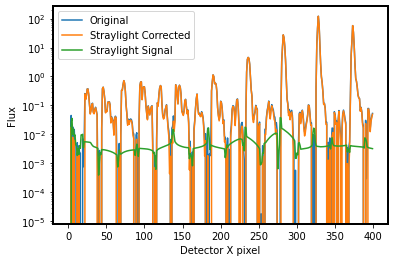

In [40]:
# It's pretty hard to see the difference by eye, so let's plot a horizontal cut across the images
plt.plot(image1[512, 0:400], label='Original')
plt.plot(image2[512, 0:400], label='Straylight Corrected')
plt.plot(image1[512, 0:400] - image2[512, 0:400], label='Straylight Signal')
plt.yscale('log')
plt.xlabel('Detector X pixel')
plt.ylabel('Flux')
plt.legend()

<b>Figure 4:</b> Horizontal cut through 2d MIRI data before and after straylight correction.  Note that the fitted straylight signal shows some peaks around the slice edges that are probably unphysical.  More work on this step will be taking place during commissioning as we learn more about what the real straylight signal looks like on orbit.

In [41]:
# Close out our files
hdu1.close()
hdu2.close()

### 4.7<font color='white'>-</font>Fringe Flat (<font color='red'>MIRI-only</font>) <a class="anchor" id="fringe"></a> ###

<div class="alert alert-block alert-warning">
This crucial step is the first pipeline correction for the strong periodic amplitude modulation (i.e., fringing) that occurs in the MIRI detectors due to internal reflections within the detectors.  In this step, the pipeline simply divides by a reference fringe flatfield to make a first-order correction to the data.  In detail, the fringing signal will depend on the geometry of sources within the scene, and thus there will be a residual fringe correction later in the pipeline too.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/fringe/index.html
</div>

In [42]:
# Call the step, specifying that we want results saved into the spec2_dir directory
for file in strayfiles:
    FringeStep.call(file, save_results=True, output_dir=spec2_dir)

2021-10-05 16:57:44,148 - stpipe.FringeStep - INFO - FringeStep instance created.
2021-10-05 16:57:44,279 - stpipe.FringeStep - INFO - Step FringeStep running with args ('./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_straylightstep.fits',).
2021-10-05 16:57:44,281 - stpipe.FringeStep - INFO - Step FringeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-10-05 16:57:45,526 - stpipe.FringeStep - INFO - Using FRINGE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_fringe_0049.fits
2021-10-05 16:57:45,581 - stpipe.FringeStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2021-10-05 16:57:45,582 - stpipe.FringeStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ

In [43]:
# Look for our fringestep.fits files produced by the fringe flat step
sstring = spec2_dir + 'det*fringestep.fits'
fringefiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
fringefiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_fringestep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_fringestep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_fringestep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_fringestep.fits']

(0.0, 250.0)

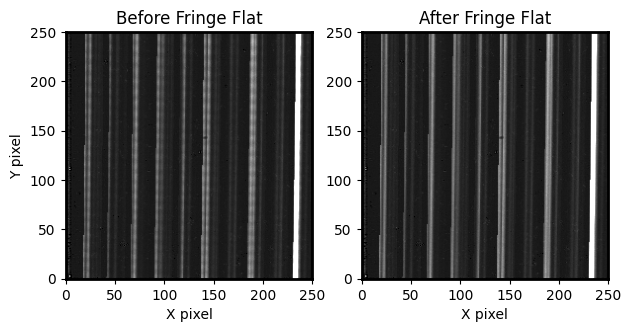

In [44]:
# Let's show what the SCI extension of the first file before/after application of the fringe flat looks like
# We'll zoom in on a region of the detector to make the results more clear
hdu1 = fits.open(strayfiles[0])
image1 = hdu1['SCI'].data
hdu2 = fits.open(fringefiles[0])
image2 = hdu2['SCI'].data

# Use a classic ZScale normalization
norm = ImageNormalize(image1, interval=ZScaleInterval(), stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data
ax1.imshow(image1, cmap='gray', origin='lower', norm=norm)
ax1.set_title('Before Fringe Flat')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')
ax1.set_xlim(0, 250)
ax1.set_ylim(0, 250)

ax2.imshow(image2, cmap='gray', origin='lower', norm=norm)
ax2.set_title('After Fringe Flat')
ax2.set_xlabel('X pixel')
ax2.set_xlim(0, 250)
ax2.set_ylim(0, 250)

<b>Figure 5:</b> MIRI 2d data before and after application of the static reference fringe flat; note that the periodic modulation in the traces has been removed (by construction perfectly for these simulated data).

In [45]:
# Close our files behind us
hdu1.close()
hdu2.close()

### 4.8<font color='white'>-</font>Path-Loss Correction (<font color='fuchsia'>NIRSpec-only</font>) <a class="anchor" id="pathloss"></a> ###

<div class="alert alert-block alert-warning">
This is a NIRSpec and NIRISS-only step that estimates flux losses from the data from such effects as light scattering outside the grating.  The relevant correction factor is determine for both point sources and uniformly extended sources by interpolation from a reference file given a known point source location.

For MIRI these corrections are folded into the flux calibration step for typical scenes, and a detector-based point source optimal extraction method that will be available sometime in Cycle 1.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pathloss/index.html
</div>

### 4.9<font color='white'>-</font>Flux Calibration <a class="anchor" id="fluxcal"></a> ###

<div class="alert alert-block alert-warning">
This step is a crucial part of the pipeline in which count-rate pixel slopes are converted to physical radiometric units by multiplying by reference files derived from observations of spectrophotometric standard sources.  In the case of the MRS, the differences in effective pixel solid angle are also accounted for in this step.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html
</div>

In [46]:
# Call the step, specifying that we want results saved into the spec2_dir directory
for file in fringefiles:
    PhotomStep.call(file, save_results=True, output_dir=spec2_dir)

2021-10-05 16:58:05,813 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2021-10-05 16:58:05,988 - stpipe.PhotomStep - INFO - Step PhotomStep running with args ('./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_fringestep.fits',).
2021-10-05 16:58:05,990 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2021-10-05 16:58:07,509 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_photom_0060.fits
2021-10-05 16:58:07,510 - stpipe.PhotomStep - INFO - Using area reference file: N/A
2021-10-05 16:58:08,894 - stpipe.PhotomStep - INFO - Using instrument: MIRI
2021-10-05 16:58:08,895 - stpipe.PhotomStep - INFO -  detector: MIR

In [47]:
# Look for our photomstep.fits files produced by the photometric calibration step
sstring = spec2_dir + 'det*photomstep.fits'
photomfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
photomfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_photomstep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_photomstep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_photomstep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_photomstep.fits']

Ordinarily we'd run the Spec2 pipeline as a pipeline rather than individual steps though, in which
case the final outputs would have the extension _cal.fits rather than _photomstep.fits <br>
Just to make the rest of this notebook more typical, we'll rename the _photomstep.fits fits to _cal.fits files

In [48]:
# Rename photomstep to cal files
calfiles = photomfiles.copy()
for ii in range(0, len(photomfiles)):
    calfiles[ii] = str.replace(photomfiles[ii], 'photomstep', 'cal')
    thisphotomfile = photomfiles[ii]
    thiscalfile = calfiles[ii]
    %mv -f $thisphotomfile $thiscalfile

(0.0, 250.0)

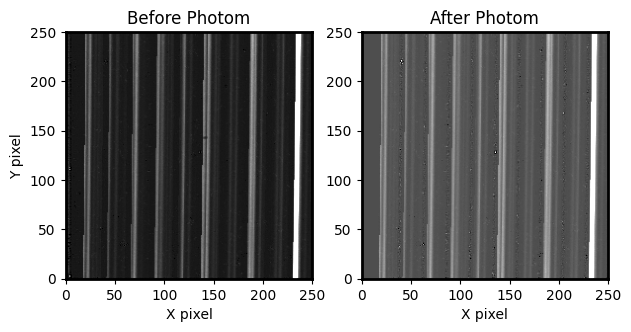

In [49]:
# Let's show what the SCI extension of the first file before/after application of the flux calibration looks like
# We'll zoom in on a region of the detector to make the results more clear
hdu1 = fits.open(fringefiles[0])
image1 = hdu1['SCI'].data
hdu2 = fits.open(calfiles[0])
image2 = hdu2['SCI'].data

# Use a classic ZScale normalization
norm1 = ImageNormalize(image1, interval=ZScaleInterval(), stretch=LinearStretch())
norm2 = ImageNormalize(image2, interval=ZScaleInterval(), stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data
ax1.imshow(image1, cmap='gray', origin='lower', norm=norm1)
ax1.set_title('Before Photom')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')
ax1.set_xlim(0, 250)
ax1.set_ylim(0, 250)

ax2.imshow(image2, cmap='gray', origin='lower', norm=norm2)
ax2.set_title('After Photom')
ax2.set_xlabel('X pixel')
ax2.set_xlim(0, 250)
ax2.set_ylim(0, 250)

<b>Figure 6:</b> MIRI 2d data before and after application of the photometric calibration reference file.

In [50]:
# Close our files behind us
hdu1.close()
hdu2.close()

### 4.10<font color='white'>-</font>Quicklook Cube Building <a class="anchor" id="spec2cube"></a> ###

<div class="alert alert-block alert-warning">
Now that we've got fully calibrated 2d detector-level data (\_photom.fits if we've run the pipeline step by step, \_cal.fits if we simply ran the spec2 pipeline as a whole) the pipeline builds some simple data cubes from each exposure.  These are multi-band data cubes that combine data from both channels on a given detector into a single data cube with a large blank region in the middle corresponding to the gap between the bands (e.g., it would create a 1A+2A data cube from the SHORT wavelength detector with the SHORT grating setting, and have an empty gap corresponding to the 1B+1C wavelength range).

We won't generally want to interact with these cubes much; they're big, unwieldy, and since they're for single exposures they aren't well sampled.  However, at the moment they're used to populate the background flux information that will be used in the Master Background step in the Spec3 pipeline and are thus necessary to produce.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/cube_build/index.html
</div>

In [51]:
# Look for our _cal.fits files
sstring = spec2_dir + 'det*cal.fits'
calfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
calfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits']

In [52]:
# Call the step, specifying that we want results saved into the spec2_dir directory

# If rerunning long pipeline steps, actually run the step
if (redolong is True):
    for file in calfiles:
        # Note that the 'multi' makes this function like in the spec2 pipeline
        CubeBuildStep.call(file, output_type='multi', save_results=True, output_dir=spec2_dir)
        
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec2_cachedir, 'det*s3d.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec2_cachedir, spec2_dir)
        shutil.copy(file, outfile)

In [53]:
# Look for our intermediate cubes produced by the cube building step
sstring = spec2_dir + 'det*s3d.fits'
cubefiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
cubefiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_s3d.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_s3d.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_s3d.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_s3d.fits']

Text(0.5, 0, 'X pixel')

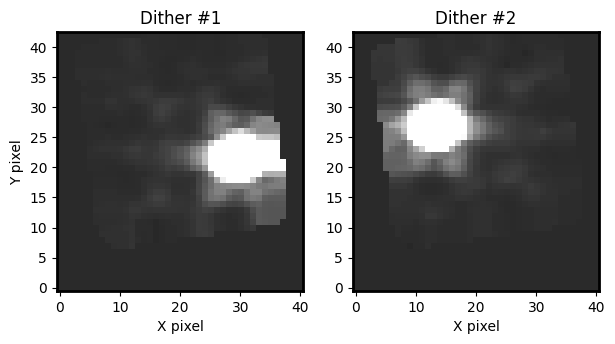

In [54]:
# Now let's display a couple of these cubes
hdu1 = fits.open(cubefiles[0])
cube1 = hdu1['SCI'].data
hdu2 = fits.open(cubefiles[1])
cube2 = hdu2['SCI'].data

# Use a linear stretch
norm = ImageNormalize(cube1[0, :, :], vmin=-200, vmax=1e3, stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data
ax1.imshow(cube1[0, :, :], cmap='gray', norm=norm, origin='lower')
ax1.set_title('Dither #1')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')

ax2.imshow(cube2[0, :, :], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Dither #2')
ax2.set_xlabel('X pixel')

<b>Figure 7:</b> MIRI rectified 3d data cubes for two different dither positions

### 4.11<font color='white'>-</font>Quicklook Spectral Extraction <a class="anchor" id="spec2x1d"></a> ###

<div class="alert alert-block alert-warning">
Now that we've got rough per-exposure data cubes, the pipeline will do a 1d spectral extraction from those cubes.  If it thinks the target is an extended source (see Source Type Identification above) it will sum up the flux from the entire field of view; if it thinks the target is a point source it will perform aperture photometry at the expected location of the source (set by the TARG_RA and TARG_DEC keywords in the primary FITS header).  At the moment there's no way to override this location short of hacking the keyword values in the FITS header, but this capability should be available soon.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/index.html
</div>

In [55]:
Extract1dStep.spec

'\n    smoothing_length = integer(default=None)  # background smoothing size\n    bkg_fit = option("poly", "mean", "median", default="poly")  # background fitting type\n    bkg_order = integer(default=None, min=0)  # order of background polynomial fit\n    bkg_sigma_clip = float(default=3.0)  # background sigma clipping threshold\n    log_increment = integer(default=50)  # increment for multi-integration log messages\n    subtract_background = boolean(default=None)  # subtract background?\n    use_source_posn = boolean(default=None)  # use source coords to center extractions?\n    apply_apcorr = boolean(default=True)  # apply aperture corrections?\n    '

In [56]:
# Call the step, specifying that we want results saved into the spec2_dir directory
for file in cubefiles:
    Extract1dStep.call(file, save_results=True, output_dir=spec2_dir)

2021-10-05 16:58:29,306 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2021-10-05 16:58:29,665 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_s3d.fits',).
2021-10-05 16:58:29,667 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}
2021-10-05 16:58:29,833 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_extract1d_0002.asdf
2021-10-05 16:58:29,845 - stpipe.Extract1dStep - INFO - Using A

In [57]:
# Look for our intermediate 1d spectra
sstring = spec2_dir + 'det*extract1dstep.fits'
specfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
specfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_extract1dstep.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_extract1dstep.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_extract1dstep.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_extract1dstep.fits']

Text(0, 0.5, 'Flux (Jy)')

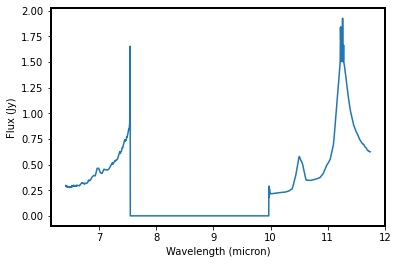

In [58]:
# Let's look at one of them
hdu = fits.open(specfiles[0])
spec = hdu['EXTRACT1D']

plt.plot(spec.data['WAVELENGTH'], spec.data['FLUX'])
plt.xlabel('Wavelength (micron)')
plt.ylabel('Flux (Jy)')

<b>Figure 8:</b> Extracted 1d spectra from the quick-look per-exposure data cube.  Note that in this case we've got spectra in 1A and 2A together in the same spectrum with zeros in between where there is no coverage.

In [59]:
# In case you forget the units, they're in the FITS header
print(spec.header['TTYPE1'], spec.header['TUNIT1'])
print(spec.header['TTYPE2'], spec.header['TUNIT2'])

WAVELENGTH um
FLUX Jy


In [60]:
# Close our files behind us
hdu.close()

In [61]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 347.0701 seconds


We're now done with the Spec2 pipeline!

<hr style="border:1px solid gray"> </hr>

5.<font color='white'>-</font>Spec3 Pipeline <a class="anchor" id="spec3"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our simulated data through the Spec3 pipeline in order to produce Lvl3 data products (i.e., calibrated combined data cubes and extracted 1d spectra).

Instead of calling each step in Spec3 individually, we will instead call the overall Spec3 pipeline with various steps turned on/off in order to demonstrate the operation of each of these steps.  In part this is to reduce the number of intermediate files that get produced- in pipeline mode the output from one step feeds transparently into the next without needing to produce additional output files.  In addition, most of the steps in Spec3 are difficult to evaluate on their own merits and their effects only become clearly visible once the resulting data have been fed through cube building to produce a final 3d data product.

Spec3 can also become significantly more complex than previous stages in that it can process data from multiple different wavelength bands together.  In the present notebook we focus only on the basic operation of the Spec3 steps for a single wavelength band- the interaction between many different bands is treated in greater detail in MRS Calibration Notebook #2 (JWebbinar Series #5 on IFU spectroscopy).

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html
</div>

### 5.1<font color='white'>-</font>Association Files <a class="anchor" id="l3assoc"></a> ###

<div class="alert alert-block alert-warning">
The Spec3 pipeline is the first place where we really have to deal with many files at the same time and how they interact with each other (i.e., background observations, dithered observations, etc).  As such, we need to create an 'Association File' describing these files and how they should be treated by the pipeline.  These files are still under some development, and the recommended methods of using them will likely change before Cycle 1.  We'll therefore define a function to create a very simple association file that will treat all exposures it is given as science exposures to be combined together.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/index.html
</div>

In [62]:
# Define a useful function to write out a Lvl3 association file from an input list
def writel3asn(files, asnfile, prodname, **kwargs):
    # Define the basic association of science files
    asn = afl.asn_from_list(files, rule=DMS_Level3_Base, product_name=prodname)
    # Add any background files to the association
    if ('bg' in kwargs):
        for bgfile in kwargs['bg']:
            asn['products'][0]['members'].append({'expname': bgfile, 'exptype': 'background'})
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

### 5.2<font color='white'>-</font>Moving Target WCS <a class="anchor" id="spec3wcs"></a> ###

<div class="alert alert-block alert-warning">
This step modifies the WCS embedded in the individual calibrated frames to account for motion of the target between individual frames (e.g., for solar system objects) such that the WCS for all frames is centered at the average location of the target within the association.

Since this step represents a rather specialized use case we will skip it for purposes of this notebook.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_mtwcs/main.html
</div>

### 5.3<font color='white'>-</font>Master Background Subtraction <a class="anchor" id="masterbg"></a> ###

<div class="alert alert-block alert-warning">
As described above, the MIRI MRS is expected to see a significant thermal and zodiacal background that needs to be subtracted from the science data.  In the Master Background step, we construct a model of the background and subtract it from the data.  This can produce significantly higher SNR results than simply doing a pixel-by-pixel subtraction of the background reference data, but it will not be known until flight if the results from this approach will be satisfactory.  As such, this step of the pipeline is still undergoing some development and is focused around processing of extended source observations with dedicated background pointings.

Since this is not the use case that we're exploring in this notebook, we will skip this step for now (an annular background will be subtracted in the Extract1D stage).

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/master_background/index.html
</div>

### 5.4<font color='white'>-</font>Residual Background Matching (<font color='red'>MIRI-only</font>) <a class="anchor" id="residbg"></a> ###

<div class="alert alert-block alert-warning">
Since the thermal background at MIRI wavelength is significant, there is the possibility that it could vary in undesirable ways between exposures.  As such, a single background image would be insufficient to bring all exposures to the same level.  The residual background matching step therefore ensures that the low-order background is consistent across all exposures.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/mrs_imatch/index.html
</div>

In [63]:
# Read in two calibrated frames
# Look for our _rate.fits files produced by the Detector1 pipeline
sstring = spec2_dir + 'det*cal.fits'
calfiles = sorted(glob.glob(sstring))
calfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits']

In these simulations the background doesn't vary, but let's pretend that it did.
We'll crudely hack one of the files to mimic a background level shift.

In [64]:
hdu = fits.open(calfiles[0])
hdu['SCI'].data += 300 # Hack this first file to add a pedestal offset
hdu.writeto(spec2_dir+'rbm_test.fits', overwrite=True)
hdu.close()

In [65]:
# Now we'll create an association file including this hacked exposure
testfiles = calfiles.copy()
testfiles[0] = spec2_dir + 'rbm_test.fits'
writel3asn(testfiles, 'rbm.json', 'rbm')

# And run it through cube building (we'll just build a cube for the Ch2 data as an example to save time), calling the output
# file 'rbm_before'
cb = CubeBuildStep()

# If rerunning long pipeline steps, actually run the step
if (redolong is True):
    cb.call('rbm.json', channel='2', save_results=True, output_dir=spec3_dir, output_file='rbm_before')
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec3_cachedir, 'rbm_before*s3d.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec3_cachedir, spec3_dir)
        shutil.copy(file, outfile)

2021-10-05 17:01:10,348 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


In [66]:
# And for comparison we'll run this association through the Spec3 pipeline with just Residual Background Matching and Cube Build,
# calling the output 'rbm_after'
spec3 = Spec3Pipeline()
spec3.output_dir = spec3_dir
spec3.save_results = True
spec3.master_background.skip = True
spec3.outlier_detection.skip = True
spec3.cube_build.channel = '2'
spec3.cube_build.output_file = 'rbm_after'
spec3.extract_1d.skip = True

# If rerunning long pipeline steps, actually run the step
if (redolong is True):
    spec3('rbm.json')
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec3_cachedir, 'rbm_after*s3d.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec3_cachedir, spec3_dir)
        shutil.copy(file, outfile)

2021-10-05 17:01:10,403 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2021-10-05 17:01:10,405 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-10-05 17:01:10,408 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2021-10-05 17:01:10,410 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2021-10-05 17:01:10,413 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-10-05 17:01:10,415 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2021-10-05 17:01:10,418 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2021-10-05 17:01:10,420 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2021-10-05 17:01:10,422 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


Text(0.5, 0, 'X pixel')

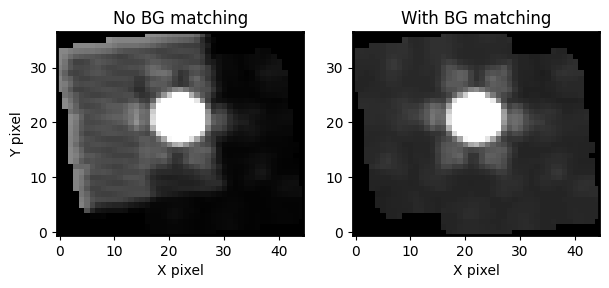

In [67]:
# Now let's compare what the SCI data of the two resulting cubes looks like
hdu1 = fits.open(spec3_dir + 'rbm_before_ch2-long_s3d.fits')
cube1 = hdu1['SCI'].data
hdu2 = fits.open(spec3_dir + 'rbm_after_ch2-long_s3d.fits')
cube2 = hdu2['SCI'].data

# Use a classic ZScale normalization
norm = ImageNormalize(cube1[0, :, :], interval=ZScaleInterval(), stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data
ax1.imshow(cube1[0, :, :], cmap='gray', norm=norm, origin='lower')
ax1.set_title('No BG matching')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')

ax2.imshow(cube2[0, :, :], cmap='gray', norm=norm, origin='lower')
ax2.set_title('With BG matching')
ax2.set_xlabel('X pixel')

<b>Figure 9:</b> Data cubes built with and without residual background matching.  The example with background matching clear looks much better!  We should therefore be sure to use this step if such patterns are visible in the data.  Note that the pipeline doesn't know what the 'true' background level should be, so it brings everything to the same average level in spatially overlapping regions (i.e., if you're mosaicing a nebula it won't try to make all parts of the nebular have the same flux, just all exposures of a given point in the nebula should be the same).

In [68]:
# Close our files behind us
hdu1.close()
hdu2.close()

### 5.5<font color='white'>-</font>Outlier Detection <a class="anchor" id="orej"></a> ###

<div class="alert alert-block alert-warning">
In general, cosmic rays should have been flagged in the Detector1 pipeline as jumps in the readout ramp and corrected when determining the final slope image.  However, sometimes fainter cosmic rays slip through Detector1, and other outliers (due to bad pixels, etc) can be present that cause artifacts in the final data cubes.  The Outlier Detection routine is designed to identify and flag these artifacts.

In brief, it builds a data cube from each individual exposure on a common data cube grid, and median combines the cubes to construct a cleaned cube.  This cleaned cube is mapped back to the 2d calibrated detector data of each exposure, and outliers in individual frames with respect to this mapped-back data are flagged.  When we next do cube building, it will use this updated flagging to construct our high-quality combined data cube.

Since the IFUs are significantly undersampled however, we need to be careful not to accidentally flag point source as outliers since the fluxes can change significantly between different pointings.  Note also that outlier detection cannot detect outliers when there are just 2 or fewer frames; therefore even in a four-point dither pattern it will only be able to work in the central regions where all four exposures overlap.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/index.html
</div>

As for residual background matching, there aren't generally many outliers in mirisim simulated data for us to demonstrate this algorithm on.
Therefore, we'll add some outliers into a copy of the simulated data and show that they get successfully flagged and rejected.

In [69]:
# Read in four calibrated frames
# Look for our _rate.fits files produced by the Detector1 pipeline
sstring = spec2_dir + 'det*cal.fits'
calfiles = sorted(glob.glob(sstring))
# And print them out so that we can see them
calfiles

['./stage2/det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits',
 './stage2/det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits']

In [70]:
# We'll crudely hack the first files to introduce a artifact on column 925 and write it back out to an _odhack.fits files
hdu = fits.open(calfiles[0])
data = hdu['SCI'].data
data[:, 925] = 13000
hdu['SCI'].data = data
hdu.writeto(str.replace(calfiles[0], 'cal', 'od_test'), overwrite=True)
hdu.close()

In [71]:
# Now we'll create an association file including these hacked exposures
testfiles = calfiles.copy()
testfiles[0] = str.replace(calfiles[0], 'cal', 'od_test')
writel3asn(testfiles, 'od.json', 'od')

# And run it through cube building (we'll just build a cube for the Ch2 data as an example to save time),
# calling the result 'od_before'
cb = CubeBuildStep()

# If rerunning long pipeline steps, actually run the step
if (redolong is True):
    cb.call('od.json', channel='2', save_results=True, output_dir=spec3_dir, output_file='od_before')
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec3_cachedir, 'od_before*s3d.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec3_cachedir, spec3_dir)
        shutil.copy(file, outfile)

2021-10-05 17:01:10,906 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


In [72]:
# And for comparison we'll run this association through the Spec3 pipeline with just 
# Outlier Detection and Cube Build, saving our final cube as 'od_after'

# This initial setup is just to make sure that we get the latest parameter reference files
# pulled in for our files.  This is a temporary workaround to get around an issue with
# how this pipeline calling method works.
crds_config = Spec3Pipeline.get_config_from_reference('od.json')
spec3 = Spec3Pipeline.from_config_section(crds_config)

# Now make any modifications to the pipeline specification
spec3.output_dir = spec3_dir
spec3.save_results = True
spec3.master_background.skip = True
spec3.mrs_imatch.skip = True
spec3.outlier_detection.save_intermediate_results = True # We'll write out intermediate files to explore what they look like
spec3.cube_build.channel = '2'
spec3.cube_build.output_file = 'od_after'
spec3.extract_1d.skip = True

# If rerunning long pipeline steps, actually run the step
if (redolong is True):
    spec3('od.json')
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec3_cachedir, 'od_after*s3d.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec3_cachedir, spec3_dir)
        shutil.copy(file, outfile)
    sstring = os.path.join(spec3_cachedir, '*crf.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec3_cachedir, spec3_dir)
        shutil.copy(file, outfile)

2021-10-05 17:01:18,637 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0050.asdf
2021-10-05 17:01:18,650 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters are {'scale': '7.5 7.5'}
2021-10-05 17:01:26,139 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2021-10-05 17:01:26,141 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-10-05 17:01:26,143 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2021-10-05 17:01:26,144 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2021-10-05 17:01:26,147 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-10-05 17:01:26,150 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2021-10-05 17:01:26,152 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


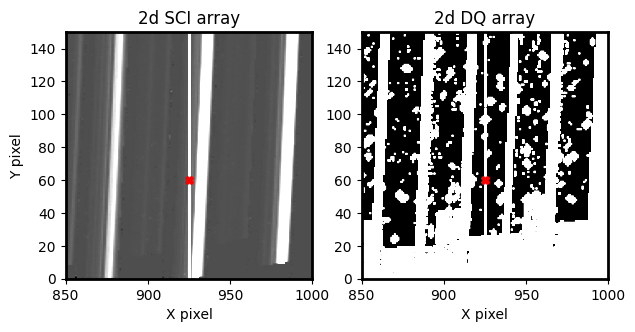

In [73]:
# Show the image and mask
hdu = fits.open(spec3_dir + 'det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test_a3001_crf.fits')
flux = hdu['SCI'].data
dq = hdu['DQ'].data

# Use a classic ZScale normalization
norm = ImageNormalize(flux, interval=ZScaleInterval(), stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data.  Highlight a pixel in the bad column with a red X
ax1.imshow(flux, cmap='gray', norm=norm, origin='lower')
ax1.set_title('2d SCI array')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')
ax1.set_xlim(850, 1000)
ax1.set_ylim(0, 150)
ax1.plot([925], [60], 'X', color='red')

ax2.imshow(dq, cmap='gray', vmin=0, vmax=1, origin='lower')
ax2.set_title('2d DQ array')
ax2.set_xlabel('X pixel')
ax2.set_xlim(850, 1000)
ax2.set_ylim(0, 150)
ax2.plot([925], [60], 'X', color='red')

<b>Figure 10:</b> SCI and ERR extensions for a MIRI 2d calibrated detector image in which one column has been deliberately set to an erroneous value.  Note that the DQ array identifies this erroneous column after the outlier detection step has been run.

That DQ array is pretty messy!  What is it telling us?
We can see that the column is flagged in our DQ array; let's examine what the DQ flag value is

In [74]:
print(dq[60, 925])

17


That's not very useful on its own, but we can ask the pipeline to tell us what this DQ flag value actually means:

In [75]:
dqflags.dqflags_to_mnemonics(dq[60, 925], mnemonic_map=datamodels.dqflags.pixel)

{'DO_NOT_USE', 'OUTLIER'}

That is, it's now been flagged as an OUTLIER and warned the pipeline not to use it!  Now let's compare what the 3d cubes with and without outlier detection look like.

In [76]:
# Close our files behind us
hdu.close()

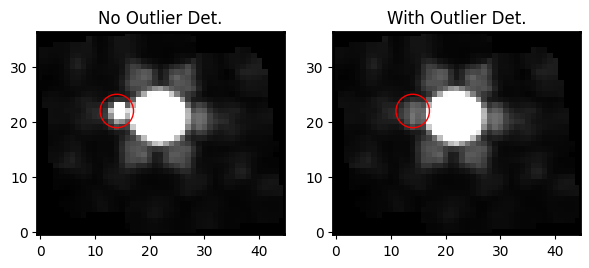

In [77]:
# Cube without outlier rejection
hdu1 = fits.open(spec3_dir + 'od_before_ch2-long_s3d.fits')
flux1 = hdu1['SCI'].data

# Cube with outlier rejection
hdu2 = fits.open(spec3_dir + 'od_after_ch2-long_s3d.fits')
flux2 = hdu2['SCI'].data

# Use a classic ZScale normalization
norm = ImageNormalize(flux1, interval=ZScaleInterval(), stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data.  Highlight a pixel in the bad column with a red X
ax1.imshow(flux1[0, :, :], cmap='gray', norm=norm, origin='lower')
ax1.set_title('No Outlier Det.')
ax1.scatter([14], [22], s=580, facecolors='none', edgecolors='r')

ax2.imshow(flux2[0, :, :], cmap='gray', norm=norm, origin='lower')
ax2.set_title('With Outlier Det.')
ax2.scatter([14], [22], s=580, facecolors='none', edgecolors='r')

<b>Figure 11:</b> 3d data cubes constructed with and without the outlier detection step.  The red circle denotes the location of the outlier that we injected into the data.

In [78]:
# Close our files behind us
hdu1.close()
hdu2.close()

### 5.6<font color='white'>-</font>Cube Creation <a class="anchor" id="spec3cube"></a> ###

<div class="alert alert-block alert-warning">
Now that all of our individual exposures have been flux calibrated, background subtracted/matched, and any outliers flagged for removal, we can finally build a composite data cube from our dithered data!  Under the hood we've already been using this code for the background matching and outlier detection steps, but this step is the one that produces a 'final' 3d output product from the pipeline.

Note, however, that in the example given below we're building cubes directly from the 2d calibration data (\_cal.fits files), and thus not incorporating any changes from the outlier detection or residual background matching steps.  This is why it's much simpler to run Spec3 as a pipeline (as demonstrated in MRS Notebook 2) as the relevant information is transparently passed from step to step.

A final word of caution: the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already build into the pipeline Extract1D algorithm.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/cube_build/index.html
</div>

In [79]:
# Let's create an association file with the calibrated 2d data
writel3asn(calfiles, 'l3.json', 'l3')

# And run it through cube building (we'll just build a cube for the Ch2 data as an example to save time)
cb = CubeBuildStep()

# If rerunning long pipeline steps, actually run the step
if (redolong is True):
    cb.call('l3.json', channel='2', save_results=True, output_dir=spec3_dir)
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec3_cachedir, 'l3*s3d.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec3_cachedir, spec3_dir)
        shutil.copy(file, outfile)

2021-10-05 17:01:27,169 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


We can also build data cubes with a different rotation convention.  By default, cubes are built in the 'skyalign' system, in which N is up and E is left.  However, we can also build them in the 'ifualign' system, in which the axes of the cube are tied to the physical axes of the IFU footprint; let's call it 'rotated'.

In [80]:
# Build a rotated-frame cube

cb = CubeBuildStep()

# If rerunning long pipeline steps, actually run the step
if (redolong is True):
    cb.call('l3.json', channel='2', save_results=True, output_dir=spec3_dir, coord_system='ifualign', output_file='rotated')
# Otherwise, just copy cached outputs into our output directory structure
else:
    sstring = os.path.join(spec3_cachedir, 'rotated*s3d.fits')
    files = sorted(glob.glob(sstring))
    for file in files:
        outfile = str.replace(file, spec3_cachedir, spec3_dir)
        shutil.copy(file, outfile)

2021-10-05 17:01:27,231 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


Text(0.5, 1.0, 'IFUALIGN')

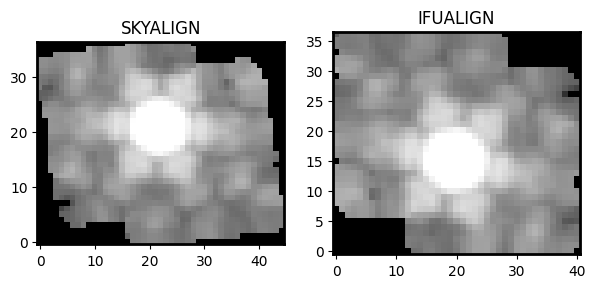

In [81]:
# Let's take a quick look at these two cubes
# Cube without outlier rejection
hdu1 = fits.open(spec3_dir + 'l3_ch2-long_s3d.fits')
flux1 = hdu1['SCI'].data

# Cube with outlier rejection
hdu2 = fits.open(spec3_dir + 'rotated_ch2-long_s3d.fits')
flux2 = hdu2['SCI'].data

# Use a classic ZScale normalization with a logarithmic stretch to make sure that
# we can see the actual cube footprint well
norm = ImageNormalize(flux1, interval=ZScaleInterval(), stretch=LogStretch())

rc('axes', linewidth=2)            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7), dpi=100)

# And plot the data.  Highlight a pixel in the bad column with a red X
ax1.imshow(flux1[0, :, :], cmap='gray', norm=norm, origin='lower')
ax1.set_title('SKYALIGN')

ax2.imshow(flux2[0, :, :], cmap='gray', norm=norm, origin='lower')
ax2.set_title('IFUALIGN')

<b>Figure 12:</b> MIRI data cubes constructed using the 'skyalign' and 'ifualign' coordinate reference frames.  Both have full WCS information embedded in the data so that they can be (e.g.) displayed similarly using tools such as ds9.

In [82]:
# Close our files behind us
hdu1.close()
hdu2.close()

### 5.7<font color='white'>-</font>Spectral Extraction <a class="anchor" id="spec3x1d"></a> ###

<div class="alert alert-block alert-warning">
This step extracts a 1-dimensional spectrum from the final composite 3d data cube.  As for the spectral extraction on a per-exposure basis at the end of the Spec2 pipeline, it will sum the entire field of view for EXTENDED sources, and perform aperture photometry at the nominal source location for POINT sources (which includes both background subtraction using an annular ring to define the background signal, and aperture correction).

In practice, for many science cases the 3d data cubes will be much to complex to be distilled down to a single 1-dimensional spectrum.  With the exception of genuine point sources, the 1d extracted spectra should thus be viewed as a convenience rather than the end-stage product to be used for scientific analysis.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/index.html
</div>

In [83]:
# Run the Extract1D step on the final 3d cube
cubefile = spec3_dir + 'l3_ch2-long_s3d.fits'
Extract1dStep.call(cubefile, save_results=True, output_dir=spec3_dir)

2021-10-05 17:01:27,935 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2021-10-05 17:01:28,261 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('./stage3/l3_ch2-long_s3d.fits',).
2021-10-05 17:01:28,264 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage3/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}
2021-10-05 17:01:28,511 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_extract1d_0002.asdf
2021-10-05 17:01:28,525 - stpipe.Extract1dStep - INFO - Using APCORR file /Users/dlaw/crd

<MultiSpecModel from l3_ch2-long_extract1dstep.fits>

Text(0, 0.5, 'Flux (Jy)')

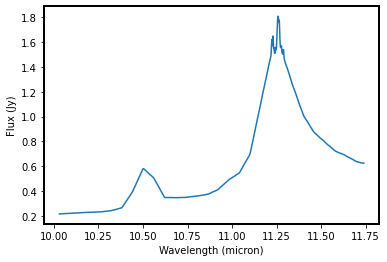

In [84]:
# Let's look at the result
specfile = spec3_dir + 'l3_ch2-long_extract1dstep.fits'

# Let's look at one of them
hdu = fits.open(specfile)
spec = hdu['EXTRACT1D']

plt.plot(spec.data['WAVELENGTH'], spec.data['FLUX'])
plt.xlabel('Wavelength (micron)')
plt.ylabel('Flux (Jy)')

<b>Figure 13:</b> Extracted 1d spectrum for band 2C

In [85]:
# Close our files behind us
hdu.close()

In [86]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 376.8884 seconds


We're now done with the Spec3 pipeline!

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/stsci_logo.png" alt="stsci_logo" width="200px"/> 